# Create Track Workbook

The process to create a new DeepRacer Track

1. Start with a track.
1. Edit the center-line waypoints (cut, slices, add)
1. Create a smoothed version.
1. Adjust size
1. Export Numpy and SVG versions

In [70]:
import glob
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import textwrap

In [71]:
def chaikins_corner_cutting(coords, refinements=5):
    _coords = np.array(coords)

    for _ in range(refinements):
        L = _coords.repeat(2, axis=0)
        R = np.empty_like(L)
        R[0] = L[0]
        R[2::2] = L[1:-1:2]
        R[1:-1:2] = L[2::2]
        R[-1] = L[-1]
        _coords = L * 0.75 + R * 0.25

    return _coords

In [72]:
from shapely.geometry import LineString

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    """
    Plota as coordenadas dos waypoints (linha central, borda interna e externa) diretamente usando Matplotlib.
    """
    # Plota a linha central
    line = LineString(waypoints)
    x, y = line.xy
    ax.plot(x, y, color="orange", linewidth=2, label="Center Line")
    ax.scatter(x, y, color="white", s=10)  # Marca os pontos dos waypoints

    # Plota a borda interna
    line = LineString(inner_border_waypoints)
    x, y = line.xy
    ax.plot(x, y, color="blue", linewidth=2, label="Inner Border")
    ax.scatter(x, y, color="white", s=10)  # Marca os pontos da borda interna

    # Plota a borda externa
    line = LineString(outer_border_waypoints)
    x, y = line.xy
    ax.plot(x, y, color="green", linewidth=2, label="Outer Border")
    ax.scatter(x, y, color="white", s=10)  # Marca os pontos da borda externa

    # Adiciona uma legenda (opcional)
    ax.legend()


## Load the track to work on

In [87]:
# Replace the name here with the track to analyze
TRACK_NAME = '2022_reinvent_champ'
TARGET_TRACK_NAME = 'Inteli'
CENTER_LINE_WIDTH = 25
OUTER_LINE_WIDTH = 25
TRACK_WIDTH = 940
SIZE_ADJUST = 0

In [ ]:
# Load the track and waypoints
df_center = pd.read_csv("./linha_central_.csv")
df_inner = pd.read_csv("./linha_interna_.csv")
df_out = pd.read_csv("./linha_externa_.csv")

center_waypoints = list(zip(df_center['X'], df_center['Y']))
inner_waypoints = list(zip(df_inner['X'], df_inner['Y']))
outer_waypoints = list(zip(df_out['X'], df_out['Y']))


print(f"center {center_waypoints}")
print(f"inner {inner_waypoints}")
print(f"outer {outer_waypoints}")


center [(-21.82975578308105, 16.00079345703125), (-20.78114128112793, 16.183101654052734), (-19.739643096923828, 16.01974868774414), (-18.91838836669922, 15.34825038909912), (-18.16864585876465, 14.590840339660645), (-17.452489852905273, 13.801609992980955), (-16.77851104736328, 12.976158142089844), (-16.163244247436523, 12.106194496154783), (-15.613615036010742, 11.193158149719238), (-15.058334350585938, 10.283729553222656), (-14.374130249023438, 9.469810485839844), (-13.466150283813477, 8.923914909362793), (-12.417306900024414, 8.770707130432129), (-11.363977432250977, 8.917643547058105), (-10.346458435058594, 9.232345581054688), (-9.36606216430664, 9.649638175964355), (-8.409475326538086, 10.119501113891602), (-7.464845657348633, 10.613080024719238), (-6.526132583618164, 11.117841720581056), (-5.58966064453125, 11.626757621765137), (-4.652250289916992, 12.133940696716309), (-3.710172653198242, 12.632384300231934), (-2.758420944213867, 13.112065315246582), (-1.796916961669922, 13.571

Is loop/ring?  True
Length: 105.33,106.03,106.73
Width: 0.24


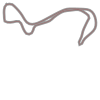

In [89]:
# Convert to Shapely objects
center_line = center_waypoints
inner_border = inner_waypoints
outer_border = outer_waypoints
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)

road_poly = Polygon(np.vstack((outer_border, np.flipud(inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
print("Length: {:0.2f},{:0.2f},{:0.2f}".format(l_inner_border.length, l_center_line.length, l_outer_border.length))
print("Width: {:0.2f}".format(l_inner_border.interpolate(0).distance(l_outer_border.interpolate(0))))
road_poly

## Display the original track waypoints

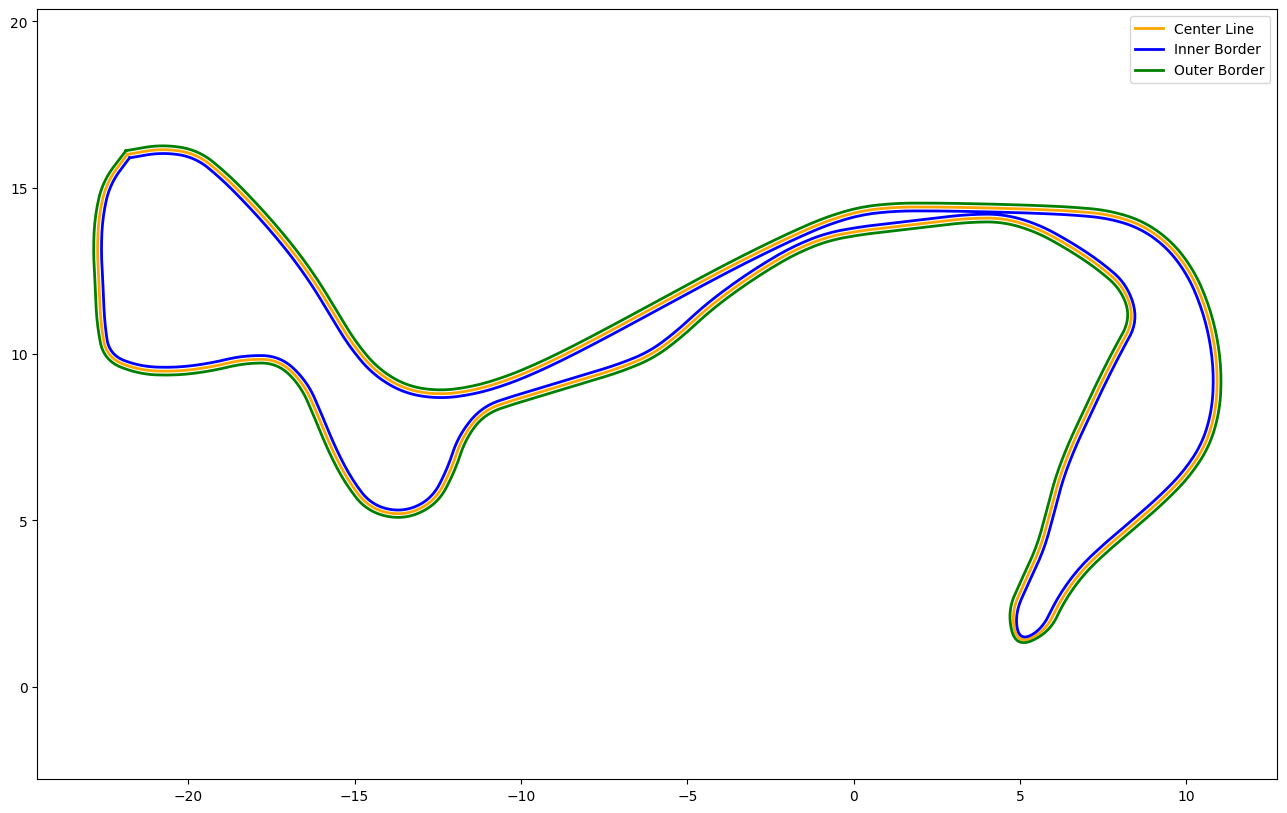

In [90]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='white')
plt.axis('equal')

center_line_loop = np.vstack([center_line, center_line[0]])
inner_line_loop = np.vstack([inner_border, inner_border[0]])
outer_line_loop = np.vstack([outer_border, outer_border[0]])
smooth_center = chaikins_corner_cutting(center_line_loop, refinements=3)
smooth_inner = chaikins_corner_cutting(inner_line_loop, refinements=3)
outer_inner = chaikins_corner_cutting(outer_line_loop, refinements=3)
print_border(ax, smooth_center, smooth_inner, outer_inner)

## Create new Polygons

In [91]:
# Convert into millimeter (needed for SVG) - reduce size of center-line with 10 cm.
center_polygon_reduced = Polygon(smooth_center*1000).buffer(SIZE_ADJUST)

# Normalize position (x and y) 
x_val = np.array(center_polygon_reduced.exterior.xy[0])
x_moved = x_val - min(x_val) + TRACK_WIDTH/2

y_val = np.array(center_polygon_reduced.exterior.xy[1])
y_moved = y_val - min(y_val) + TRACK_WIDTH/2

# Stack into two-column numpy
smooth_center_moved = np.column_stack((x_val, y_val))

print(f"smooth_center_moved {smooth_center_moved}")

smooth_center_moved [[-21829.75578308  16000.79345703]
 [-21813.37118149  16003.64202261]
 [-21780.6019783   16009.33915377]
 ...
 [-21859.43603516  15960.88249981]
 [-21839.64920044  15987.48980463]
 [-21829.75578308  16000.79345703]]


In [92]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

# Supondo que você já tenha o `smooth_center_moved` definido, vamos criar o polígono
center_polygon_moved_reduced = Polygon(smooth_center_moved)  # Ou substitua se for MultiPolygon

# Filled polygon -- exterior is center-line
center_polygon_moved_reduced = Polygon(smooth_center_moved)

# Polygons for outer line (both inner and outer side)
center_polygon_outer = center_polygon_moved_reduced.buffer(TRACK_WIDTH/8, join_style=1)
center_polygon_outer_border = center_polygon_outer.buffer(-OUTER_LINE_WIDTH, join_style=1)

# Polygons for inner line (both inner and outer side)
center_polygon_inner = center_polygon_moved_reduced.buffer(-TRACK_WIDTH/8, join_style=1)
center_polygon_inner_border = center_polygon_inner.buffer(OUTER_LINE_WIDTH, join_style=1)

# Diff polygons for inner line, outer line and the track surface
inner_border_p = center_polygon_inner_border.difference(center_polygon_inner)
outer_border_p = center_polygon_outer.difference(center_polygon_outer_border)
track_p = center_polygon_outer.difference(center_polygon_inner)

# Start line
start_center_point = center_polygon_moved_reduced.exterior.interpolate(0.0, normalized=True)

print(center_polygon_inner)

start_inner_d = center_polygon_inner.exterior.project(start_center_point, normalized=True)
start_inner_p = center_polygon_inner.exterior.interpolate(start_inner_d, normalized=True)

start_outer_d = center_polygon_outer.exterior.project(start_center_point, normalized=True)
start_outer_p = center_polygon_outer.exterior.interpolate(start_outer_d, normalized=True)

start_line_ls = LineString([start_inner_p, start_outer_p])

POLYGON ((-21763.443945760766 15893.059627296827, -21350.86073078143 15964.789802593958, -21222.10779014649 15987.174307504629, -21095.847818254202 16003.937133980025, -20969.771816012184 16015.486030774726, -20843.857030743664 16021.828474878306, -20718.07943040559 16022.96915186128, -20592.414285475086 16018.90975339895, -20466.836792424376 16009.648897494055, -20341.322702596925 15995.182178198782, -20217.252612487002 15975.722502169565, -20098.003688600787 15949.041043723044, -19982.222578110377 15914.957179647376, -19869.805234772488 15873.46687692267, -19760.647024614602 15824.54419419621, -19654.649855456613 15768.142241005396, -19551.72867847163 15704.196481371884, -19451.81638289186 15632.629854872233, -19352.66280202434 15551.55700572238, -19252.308411284142 15467.272650373689, -19153.057849543038 15381.661152180637, -19054.91052648948 15294.721964625493, -18957.86587495457 15206.45451937042, -18861.923352290403 15116.858227820105, -18767.082441634404 15025.932482762491, -186

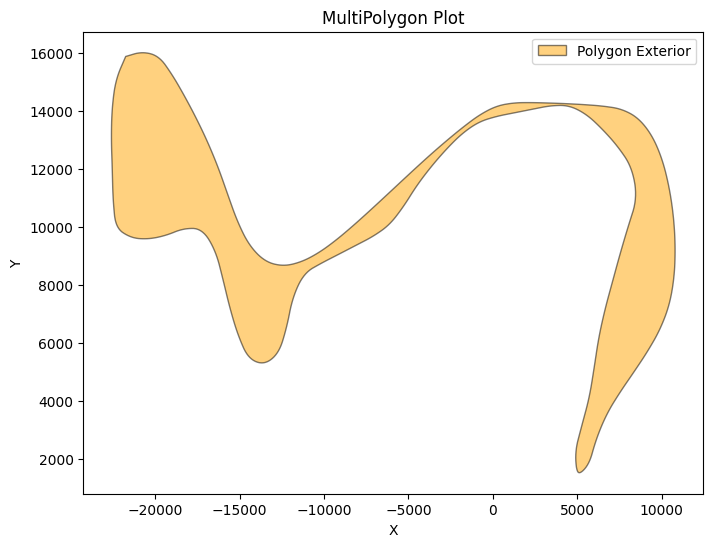

In [93]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from shapely.geometry.polygon import orient

def plot_multipolygon(multipolygon, title="MultiPolygon Plot"):
    """
    Plota um MultiPolygon ou Polygon usando matplotlib.
    
    Args:
        multipolygon: Um objeto do tipo MultiPolygon ou Polygon.
        title (str): Título do gráfico.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    
    # Verifica se é um MultiPolygon ou apenas um Polygon
    if isinstance(multipolygon, Polygon):
        multipolygon = [multipolygon]  # Transforma em uma lista para padronizar o loop
    
    if isinstance(multipolygon, MultiPolygon):
        polygons = multipolygon.geoms  # Lista de polígonos
    else:
        polygons = multipolygon  # Caso seja uma lista de polígonos
    
    # Plota cada polígono
    for poly in polygons:
        if not poly.is_empty:
            x, y = poly.exterior.xy  # Coordenadas externas
            ax.fill(x, y, alpha=0.5, fc='orange', ec='black', label="Polygon")
            
            # Plota buracos internos, se houver
            for interior in poly.interiors:
                x, y = interior.xy
                ax.plot(x, y, color='red', linestyle='--', label="Hole")
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.legend(["Polygon Exterior", "Polygon Hole"], loc="upper right")
    plt.show()
    
plot_multipolygon(center_polygon_inner)

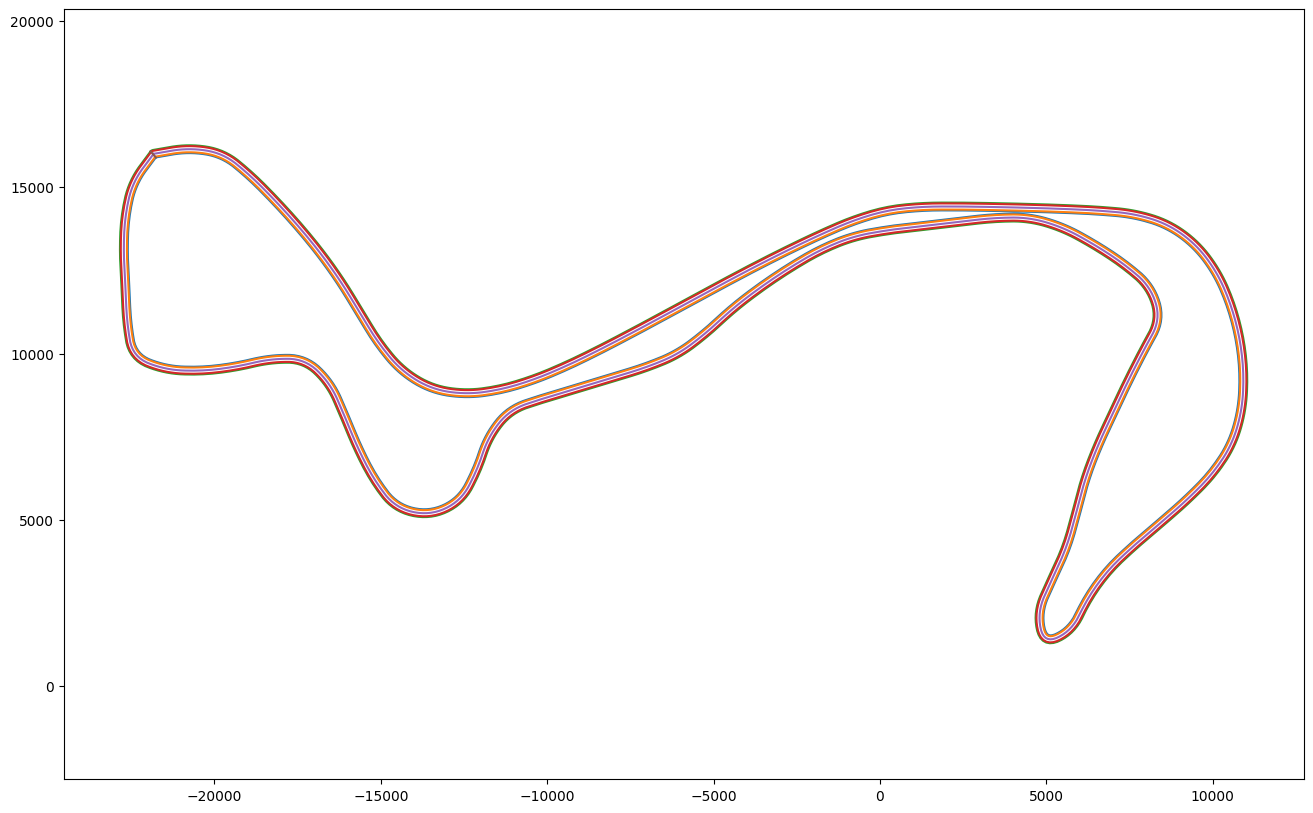

In [94]:
fig = plt.figure(1, figsize=(16, 10))

x_i, y_i = center_polygon_inner.exterior.xy
plt.plot(x_i, y_i)

x_ib, y_ib = center_polygon_inner_border.exterior.xy
plt.plot(x_ib, y_ib)

x_o, y_o = center_polygon_outer.exterior.xy # interna
plt.plot(x_o, y_o)

x_ob, y_ob = center_polygon_outer_border.exterior.xy
plt.plot(x_ob, y_ob)

x, y = center_polygon_moved_reduced.exterior.xy
plt.plot(x,y)

x_s, y_s = start_line_ls.xy
plt.plot(x_s,y_s)

# to net let the image be distorted along the axis
plt.axis('equal')
plt.show()

In [95]:
dim_x = max(x_o)-min(x_o)
dim_y = max(y_o)-min(y_o)
print(f"Track dimensions x:{(dim_x/1000):0.2f}, y:{(dim_y/1000):0.2f}")
print(f"Length: {(center_polygon_outer.exterior.length/1000):0.2f}")

Track dimensions x:33.88, y:14.97
Length: 105.88


## Create waypoints / route for Robomaker

In [96]:
POINTS=100
waypoints_new = np.zeros((POINTS+1,6))
for i in range(0,POINTS):
    p_c = center_polygon_moved_reduced.exterior.interpolate(i/POINTS, normalized=True)
    waypoints_new[i, 0] = p_c.x
    waypoints_new[i, 1] = p_c.y

    d = center_polygon_inner.exterior.project(p_c, normalized=True)
    p = center_polygon_inner.exterior.interpolate(d, normalized=True)
    waypoints_new[i, 2] = p.x
    waypoints_new[i, 3] = p.y

    d = center_polygon_outer.exterior.project(p_c, normalized=True)
    p = center_polygon_outer.exterior.interpolate(d, normalized=True)
    waypoints_new[i, 4] = p.x
    waypoints_new[i, 5] = p.y

waypoints_new[POINTS] = waypoints_new[0]

# Waypoints are in meter (we converted to mm above)
waypoints_new /= 1000.0
np.save(f"../routes/{TARGET_TRACK_NAME}", waypoints_new)

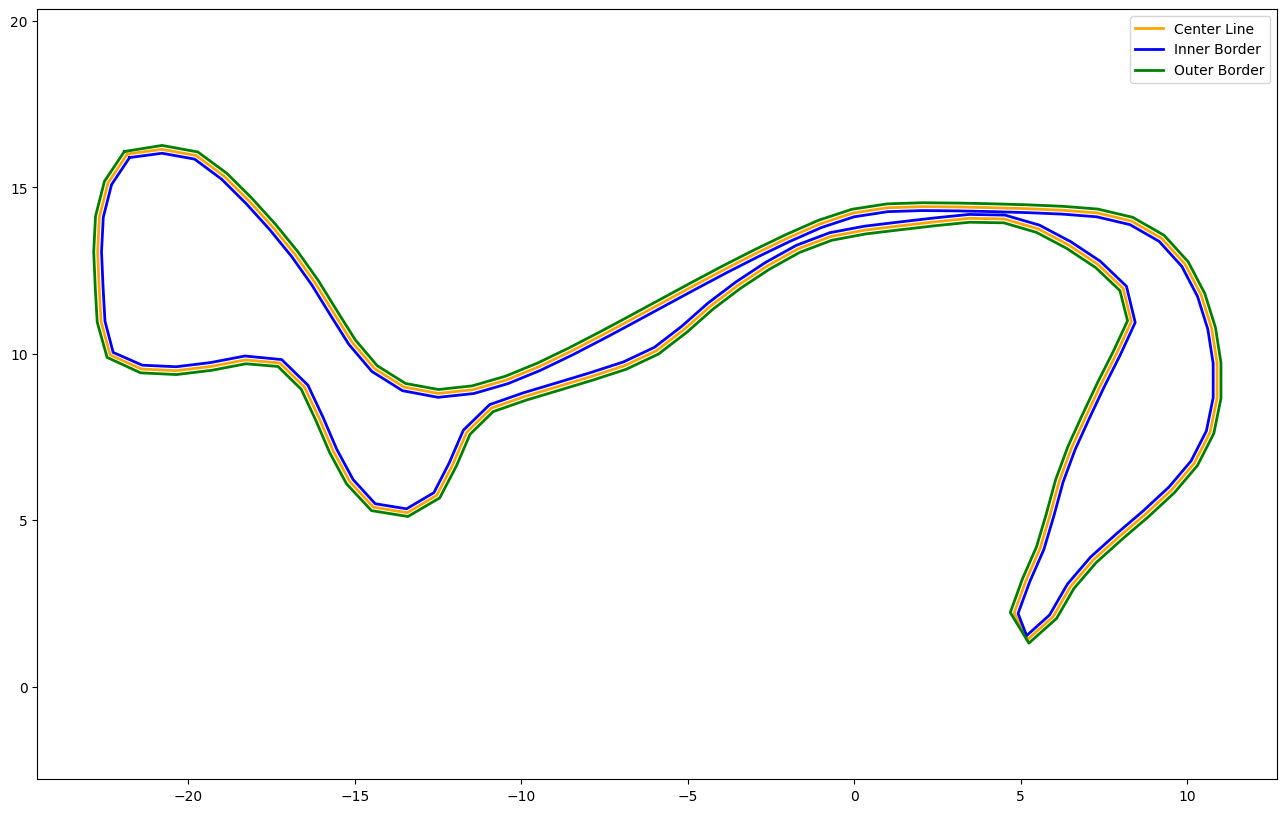

In [97]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='white')
plt.axis('equal')

print_border(ax, waypoints_new[:,0:2], waypoints_new[:,2:4], waypoints_new[:,4:6])

In [98]:
import xml.etree.ElementTree as ET

def create_svg(obj: Polygon, id: str, fill_color: str=None, fill_opacity: float=1, border_color: str=None, border_width: int=0, border_style: str=None, border_offset: int=0):
    tree = ET.ElementTree(ET.fromstring(obj.svg()))
    root = tree.getroot() 
    root.set('id', id)
    
    # Strip not-needed attributes
    root.attrib.pop("fill", None)
    root.attrib.pop("fill-rule", None)
    root.attrib.pop("stroke", None)
    root.attrib.pop("stroke-width", None)
    root.attrib.pop("opacity", None)
    
    style = ""
    
    if fill_color is None:
        style += "fill:none;"
    else:
        style += f"fill:{fill_color};"
        style += f"fill-opacity:{fill_opacity};"

    if border_color is None:
        style += "stroke:none;"
    else:
        style += f"stroke:{border_color};"
        style += f"stroke-width:{border_width};"
        style += "stroke-opacity:1;"

        if border_style is not None:
            style += f"stroke-dasharray:{border_style};"
            style += f"stroke-dashoffset:{border_offset};"

    root.set('style', style)
        
#    return ET.tostring(root, encoding='unicode')
    return root

In [99]:
doc_props = {
    'id': TARGET_TRACK_NAME,
    'version': '1.1',
    'baseProfile': 'full',
    'width': '{width:.5f}mm'.format(width = dim_x),
    'height': '{height:.5f}mm'.format(height = dim_y),
    'viewBox': '%.5f,%.5f,%.5f,%.5f' % (0, 0, dim_x*1.3, dim_y*1.3),
    'xmlns': 'http://www.w3.org/2000/svg',
    'xmlns:ev': 'http://www.w3.org/2001/xml-events',
    'xmlns:xlink': 'http://www.w3.org/1999/xlink',
    'xmlns:sodipodi': 'http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd',
    'xmlns:inkscape': 'http://www.inkscape.org/namespaces/inkscape'
}

view_props = {
    'id': 'trackview',
    'pagecolor': '#00c389',
    'bordercolor': '#000000',
    'borderopacity': '0.25'   
}

with open(f"{TARGET_TRACK_NAME}_raw.svg", 'wb') as f:
    
    svg = ET.Element("svg")
    tree = ET.ElementTree(svg)

    for key in doc_props:
        val = doc_props[key]
        svg.set(key, val)

    view = ET.SubElement(svg, "sodipodi:namedview")
    for key in view_props:
        val = view_props[key]
        view.set(key, val)

    svg.insert(1, create_svg(track_p, "road", fill_color="#232f3e", border_color=None))
    svg.insert(2, create_svg(inner_border_p, "il", fill_color="#ffffff", border_color=None))
    svg.insert(3, create_svg(outer_border_p, "ol", fill_color="#ffffff", border_color=None))
    svg.insert(4, create_svg(center_polygon_moved_reduced, "cl", fill_color=None, border_color="#ff9900", border_width=CENTER_LINE_WIDTH, border_style="50,50"))
    svg.insert(5, create_svg(start_line_ls, "start_line", fill_color=None, border_color="#ffffff", border_width=100, border_style=None))

    tree.write(f, encoding='utf-8', xml_declaration=True)


In [100]:
doc_props = {
    'id': TARGET_TRACK_NAME,
    'version': '1.1',
    'baseProfile': 'full',
    'width': '{width:.5f}mm'.format(width = dim_x),
    'height': '{height:.5f}mm'.format(height = dim_y),
    'viewBox': '%.5f,%.5f,%.5f,%.5f' % (0, 0, dim_x*1.3, dim_y*1.3),
    'xmlns': 'http://www.w3.org/2000/svg',
    'xmlns:ev': 'http://www.w3.org/2001/xml-events',
    'xmlns:xlink': 'http://www.w3.org/1999/xlink',
    'xmlns:sodipodi': 'http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd',
    'xmlns:inkscape': 'http://www.inkscape.org/namespaces/inkscape'
}

view_props = {
    'id': 'trackview',
    'pagecolor': '#ffffff',
    'bordercolor': '#000000',
    'borderopacity': '0.25',
    'inkscape:pageopacity': '0',
    'inkscape:pagecheckerboard': 'true'
}

with open(f"{TARGET_TRACK_NAME}_iconography.svg", 'wb') as f:
    
    svg = ET.Element("svg")
    tree = ET.ElementTree(svg)

    for key in doc_props:
        val = doc_props[key]
        svg.set(key, val)

    view = ET.SubElement(svg, "sodipodi:namedview")
    for key in view_props:
        val = view_props[key]
        view.set(key, val)

    svg.insert(1, create_svg(track_p, "road", fill_color="#a9a9a9", fill_opacity=0.6, border_color=None))
    svg.insert(2, create_svg(center_polygon_moved_reduced, "cl", fill_color=None, border_color="#ffffff", border_width=50))

    tree.write(f, encoding='utf-8', xml_declaration=True)
